In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
import seaborn as sns

from src.network import Layer
from src.ou_process import ouprocess_gaussian

sns.set()

In [5]:
NUM_NEURONS = 1000 # 100
tau_V = 10
R = 1 # MOhm
EL = -70.0
V_th = -40.0
dt = 0.1 # msec
t_stop = 1.0e3 # 50.0e3

In [6]:
# Slow Signal: INPUT
input_slow, _ = ouprocess_gaussian(50.0, dt, t_stop, 1)
i_inj = 16.0 + 6.0*input_slow

In [7]:
layer = Layer(NUM_NEURONS)
layer.train(i_inj=i_inj, exp_output=i_inj, dt=dt, t_stop=t_stop)
out, V, F_binary, F_synaptic = layer.output(i_inj, dt, t_stop)

C:\Users\Sayan Faraz\OneDrive\Programs\ResearchProjects\Strong AI\ReliableInfoTransfer\neural-learning\src\network.py:70: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


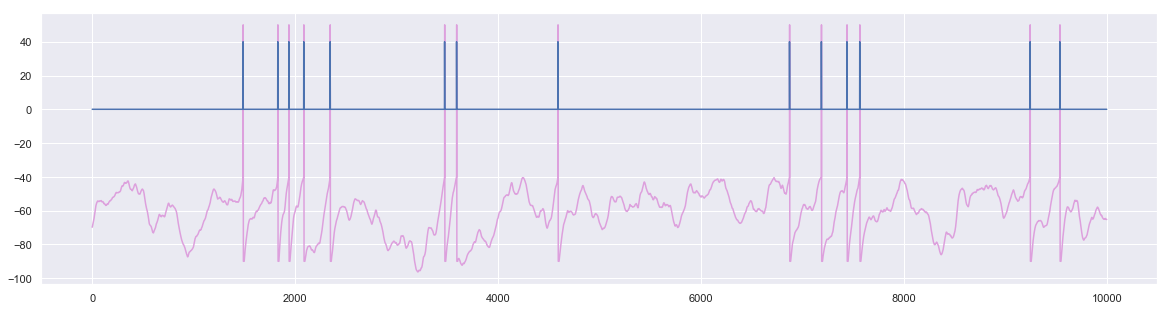

In [8]:
trial = 10
t_i = 0
t_f = -1
plt.figure(figsize=(20,5))
plt.plot(V[t_i:t_f,trial], color='plum')
plt.plot(F_binary[t_i:t_f,trial] * 40.0)
plt.show()

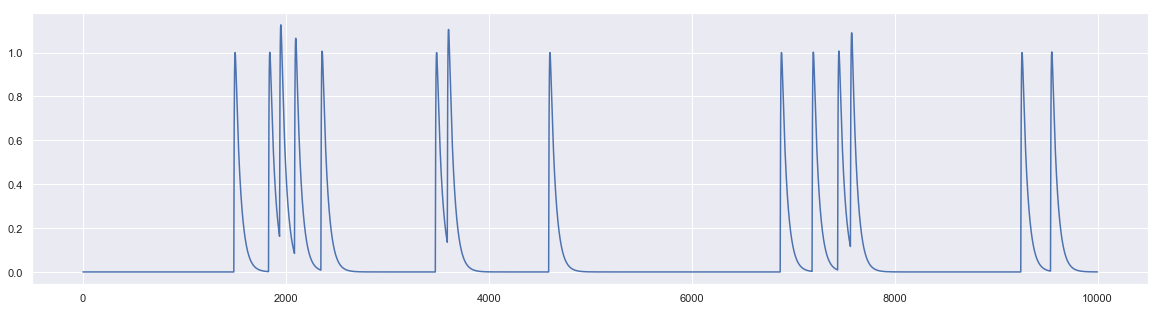

In [9]:
plt.figure(figsize=(20,5))
plt.plot(F_synaptic[:,10])

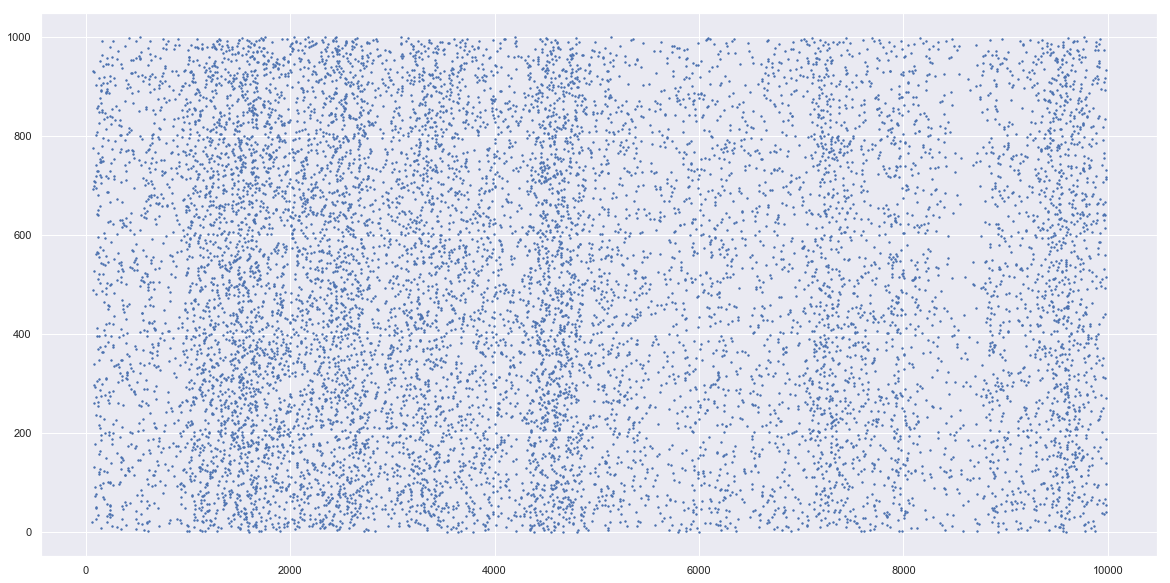

In [10]:
spike_inds, spike_trial = np.where(F_binary > 0)
plt.figure(figsize=(20,10))
plt.scatter(spike_inds, spike_trial, s=2)

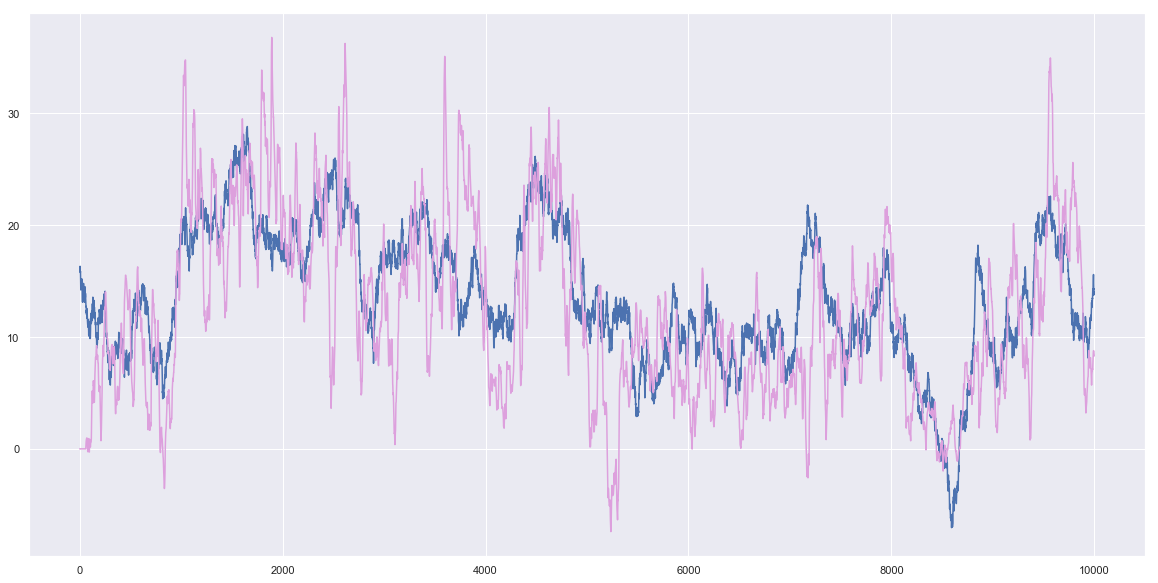

In [11]:
plt.figure(figsize=(20,10))
plt.plot(i_inj)
plt.plot(out, 'plum')

In [12]:
np.linalg.norm(out-i_inj)

623.8049705248392

In [16]:
import time
start_time = time.time()
loop_time = start_time

# Plotting L2 Norm between original signal and reconstructed signal
NUM_TRIALS = 200

l2_norms = np.zeros((NUM_TRIALS))

for i in range(NUM_TRIALS):
    input_slow, _ = ouprocess_gaussian(50.0, dt, t_stop, 1)
    i_inj = 16.0 + 6.0*input_slow
    out, V, F_binary, F_synaptic = layer.output(i_inj, dt, t_stop)
    
    l2_norms[i] = np.linalg.norm(out-i_inj)
    
    if i % 5 == 0:
        print("Trial ", i)
        print("5 Iter time: ", time.time() - loop_time)
        print("Total time: ", time.time() - start_time)
        print("\n")
        loop_time = time.time()

Trial  0
5 Iter time:  6.20306658744812
Total time:  6.20306658744812


Trial  5
5 Iter time:  34.61433005332947
Total time:  40.83352613449097


Trial  10
5 Iter time:  37.46334099769592
Total time:  78.29686713218689


Trial  15
5 Iter time:  36.35438656806946
Total time:  114.65632176399231


Trial  20
5 Iter time:  46.24784731864929
Total time:  160.9041690826416


Trial  25
5 Iter time:  33.5910222530365
Total time:  194.4951913356781


Trial  30
5 Iter time:  34.480159282684326
Total time:  228.97535061836243


Trial  35
5 Iter time:  34.607298135757446
Total time:  263.5826487541199


Trial  40
5 Iter time:  34.074339628219604
Total time:  297.6569883823395


Trial  45
5 Iter time:  35.435779333114624
Total time:  333.0927677154541


Trial  50
5 Iter time:  37.36565613746643
Total time:  370.45842385292053


Trial  55
5 Iter time:  37.92827129364014
Total time:  408.38669514656067


Trial  60
5 Iter time:  39.587584257125854
Total time:  447.97637820243835


Trial  65
5 Iter tim

In [21]:
np.savez("1e3_neur_1e3_time_200_trials.npz", layer_w=layer.W, l2_norms=l2_norms)

(array([ 2.,  4., 12.,  8., 22., 25., 32., 25., 21., 12., 11.,  6.,  6.,
         7.,  1.,  0.,  5.,  0.,  0.,  1.]),
 array([575.86441727, 592.21956233, 608.57470739, 624.92985244,
        641.2849975 , 657.64014256, 673.99528762, 690.35043268,
        706.70557774, 723.0607228 , 739.41586785, 755.77101291,
        772.12615797, 788.48130303, 804.83644809, 821.19159315,
        837.5467382 , 853.90188326, 870.25702832, 886.61217338,
        902.96731844]),
 <a list of 20 Patch objects>)

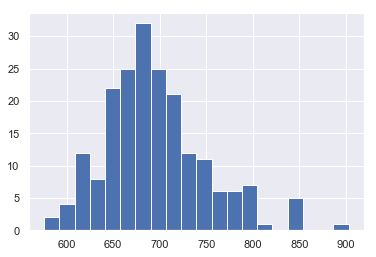

In [19]:
plt.hist(l2_norms, bins=20)

{'whiskers': [<matplotlib.lines.Line2D at 0x1eb10270ac8>,
 'caps': [<matplotlib.lines.Line2D at 0x1eb1027b208>,
 'boxes': [<matplotlib.lines.Line2D at 0x1eb10270898>],
 'medians': [<matplotlib.lines.Line2D at 0x1eb1027b908>],
 'fliers': [<matplotlib.lines.Line2D at 0x1eb1027bc88>],
 'means': []}

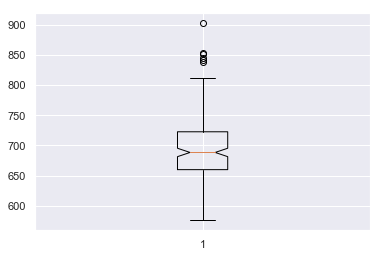

In [22]:
plt.boxplot(l2_norms, notch=True, sym="o")

In [45]:
# F_binary = np.zeros((tt.shape[0], NUM_NEURONS))
# avg_firing_rate = np.zeros(NUM_NEURONS)
# a2 = 25.0 # pA; std of noise

# I_total = a2*ETA + i_inj

# for k in range(0, NUM_NEURONS):
#     V[:,k] = lif_compute(I_total[:, k], R, tau_V, V_th, dt)

NameError: name 'tt' is not defined